## 랜덤포레스트

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Confusion matrix 시각화를 위해 추가

# 데이터 로드
iris = load_iris()
X = iris.data
#print(X)
y = iris.target
#print(y)
feature_names = iris.feature_names
target_names = iris.target_names

# Pandas DataFrame 생성
df = pd.DataFrame(data=X, columns=feature_names)
print(df.head())
df['target'] = y
df['target_names'] = [target_names[i] for i in y] # target 이름 추가

# 데이터프레임 출력 (처음 5행)
print("DataFrame Sample:")
print(df.head())

# 데이터 분할 (훈련 세트 80%, 테스트 세트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest 모델 생성
# 하이퍼파라미터 튜닝을 위해 GridSearchCV 사용
param_grid = {
    'n_estimators': [50, 100, 200],  # 트리의 개수
    'max_depth': [4, 6, 8],       # 트리의 최대 깊이
    'min_samples_split': [2, 4],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2]    # 리프 노드에 있어야 하는 최소 샘플 수
}

rf_model = RandomForestClassifier(random_state=42)  # Random Forest 모델 초기화
# 교차 검증 cv =3 : 훈련 데이터를 3개의 FOLD(묶음)으로 나누어서 두개를 훈련, 나머지는 검증 용도로 활용
# 교차 검증은 최적의 하이퍼 파라미터 값을 찾기 위해서 사용됨
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')

# 모델 학습 (GridSearchCV를 통한 최적의 파라미터를 반영한 학습)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 모델 저장
best_rf_model = grid_search.best_estimator_

# 테스트 데이터로 예측 (하이퍼 파라미터 튜닝을 통해 최적회된 상태로 예측이 이루어짐)
y_pred = best_rf_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 분류 보고서
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
DataFrame Sample:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_names  
0       0       setosa  
1

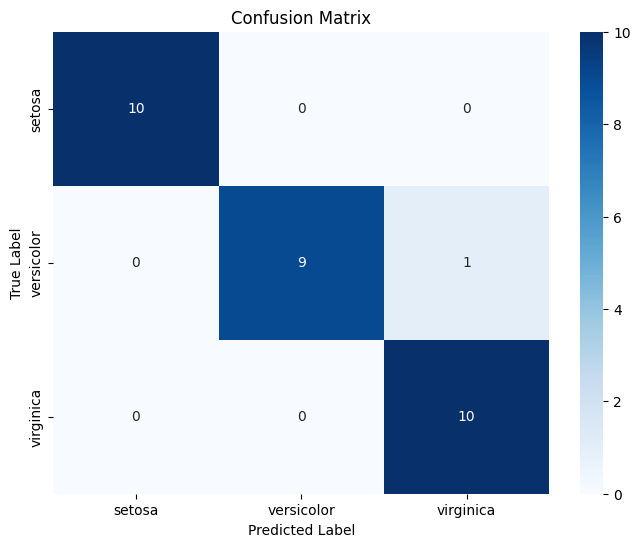

In [2]:
# 혼동 행렬 (Confusion Matrix) 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
# annot=True : 각 셀안의 숫자값을 표시, fmt="d" : 숫자값을 정수형태로 표시, cmap="Blues" : 색상값은 블루
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

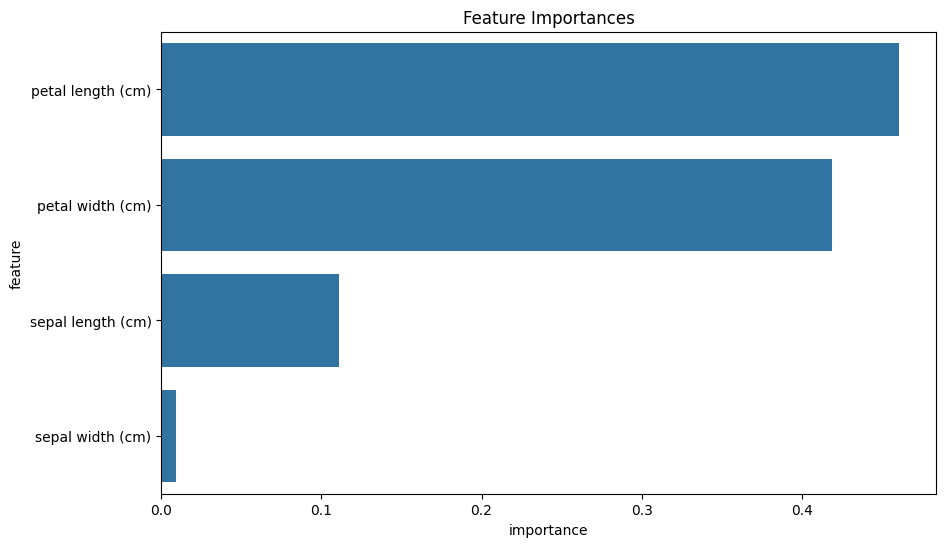

In [3]:
# Feature Importance 시각화
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

## 나이브베이즈(Naive Bayes)

### 텍스트 분류 문제에서 매우 효과적

In [13]:
"""
특정 단어의 빈도를 기준으로 판단하는 모델
"""

# 스팸분류 예제
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer  # 텍스트 데이터를 숫자로 변환 (TF-IDF 벡터화)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 불러오기
data = pd.read_csv('./dataset/spam.csv', encoding='ISO-8859-1')
# encoding='ISO-8859-1' : 서유럽권 언어를 위한 인코딩
# encoding='cp949' : 한글이 포함된 데이터를 불러올 때 사용

# 데이터 내용 미리보기 (처음 5개 행 출력)
print("Spam Data (First 5 rows):")
print(data.head()) # 여러 열이 선택됨
print("\n")

data = data[['v1', 'v2']]  # 필요한 열만 선택
data.columns = ['label', 'text']  # 열 이름 변경

# 2. 데이터 전처리
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
# 레이블을 숫자로 변환, map함수: 열의 각 값을 다른 값으로 변환하는 데 사용
data.dropna(inplace=True)  # 결측치 제거

# 3. 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# 4. TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english')
# stop_words: 불필요한 영어 단어(예: "the", "is", "and" 등)를 자동으로 제거
X_train_tfidf = vectorizer.fit_transform(X_train)
# fit: 학습 데이터의 중요한 통계정보(단어빈도수)학습, transform: 숫자 벡터로 변환
X_test_tfidf = vectorizer.transform(X_test)
# 학습 데이터의 통계정보를 그대로 사용하여 테스트 데이터 변환

# 5. 모델 학습
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 6. 예측 및 평가
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7. 샘플 테스트
sample_text = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now!",
               "Congratulations! You've been selected to receive a free iPhone 15. Click to claim now!",
               "Hey, are we meeting for lunch tomorrow?"]
sample_tfidf = vectorizer.transform(sample_text)
predictions = model.predict(sample_tfidf)
for text, label in zip(sample_text, predictions):
    print(f"Text: {text} => {'Spam' if label == 1 else 'Ham'}")
    


Spam Data (First 5 rows):
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


Accuracy: 0.9668161434977578

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      11

## SVM(Support Vector Machine)

In [ ]:
"""
데이터 공간에서 데이터를 두 클래스로 나누는 초평면을 찾아
데이터를 분리하는 모델

"""
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 불러오기
data = pd.read_csv('./dataset/spam.csv', encoding='ISO-8859-1')
data = data[['v1', 'v2']]  # 필요한 열만 선택
data.columns = ['label', 'text']  # 열 이름 변경

# 2. 데이터 전처리
data['label'] = data['label'].map({'ham': 0, 'spam': 1})  # 레이블을 숫자로 변환
data.dropna(inplace=True)  # 결측치 제거

# 3. 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# 4. TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 5. SVM 모델 학습
model = SVC(kernel='linear', random_state=42)  # SVM 모델 생성 (linear : 직선, 평면, 초평면)
model.fit(X_train_tfidf, y_train)

# 6. 예측 및 평가
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7. 샘플 테스트
sample_text = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now!",
    "Congratulations! You've been selected to receive a free iPhone 15. Click to claim now!",
    "Hey, are we meeting for lunch tomorrow?"
]
sample_tfidf = vectorizer.transform(sample_text)
predictions = model.predict(sample_tfidf)
for text, label in zip(sample_text, predictions):
    print(f"Text: {text} => {'Spam' if label == 1 else 'Ham'}")

Accuracy: 0.979372197309417

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now! => Spam
Text: Congratulations! You've been selected to receive a free iPhone 15. Click to claim now! => Spam
Text: Hey, are we meeting for lunch tomorrow? => Ham


## KNN(K 최근접 이웃) 예제

In [14]:
# KNN(K 최근접 이웃) 분류 예제
# iris 데이터셋 : 꽃받침(Sepal)과 꽃잎(Petal)의 길이 너비로 품종을 분류
# 필요한 라이브러리 임포트
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 데이터 로드
iris = load_iris()
X, y = iris.data, iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 표준화 (KNN은 거리 기반 알고리즘이므로 표준화 필요)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN 모델 생성 및 학습
knn = KNeighborsClassifier(n_neighbors=3)  # k=3
knn.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = knn.predict(X_test)

# 모델 성능 평가
print("모델 성능 평가:")
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 보고서:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

# 새로운 데이터에 대한 예측
new_samples = [
    [5.1, 3.5, 1.4, 0.2],  # Setosa
    [6.2, 3.4, 5.4, 2.3],  # Virginica
    [5.9, 3.0, 4.2, 1.5],  # Versicolor
]

new_samples = scaler.transform(new_samples)  # 표준화
predictions = knn.predict(new_samples)

print("\n새로운 데이터에 대한 예측 결과:")
for i, pred in enumerate(predictions):
    print(f"샘플 {i+1}: {iris.target_names[pred]}")

모델 성능 평가:
정확도: 1.0

분류 보고서:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


새로운 데이터에 대한 예측 결과:
샘플 1: setosa
샘플 2: virginica
샘플 3: versicolor
